In [8]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

from dataset import SyntheticBanditDatasetWithActionEmbeds
from estimator import InversePropensityScore as IPS
from policy import gen_eps_greedy
from util import ActionEmbedOffPolicyEvaluation, aggregate_simulation_results, visualize_mean_squared_error

In [5]:
# setting 1

# 変数
n_actions_list=[250, 500, 1000, 2000]

# 定数
dim_context=5
n_category=10
p_e_a_param_std=1.
random_state=12345
val_size=1000
test_size=10000
eps=0.1
reward_noise=1.0
beta=0.0
n_sim=1000
is_category_probabialistic=True
estimator_to_pscore_dict={"IPS": "action", "MIPS": "category"}

In [6]:
# experiment-1 varying n_actions under the assumption that p(r|x,a,e) = p(r|x,e)

result_df_list = []
for n_actions in n_actions_list:
    
    dataset = SyntheticBanditDatasetWithActionEmbeds(
        n_actions=n_actions,
        dim_context=dim_context,
        n_category=n_category,
        is_category_probabialistic=is_category_probabialistic,
        reward_noise=reward_noise,
        beta=beta
    )

    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size)
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        evaluation_policy=gen_eps_greedy(expected_reward=test_data["expected_reward"], eps=eps)
    )
    
    result_list = []
    for seed in tqdm(range(n_sim), desc=f"n_actions={n_actions}..."):
        
        # generate synthetic data
        dataset = SyntheticBanditDatasetWithActionEmbeds(
            n_actions=n_actions,
            dim_context=dim_context,
            n_category=n_category,
            is_category_probabialistic=is_category_probabialistic,
            reward_noise=reward_noise,
            beta=beta,
            random_state=seed
        )
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        evaluation_policy_pscore = evaluation_policy[np.arange(val_size), val_data["action"]].copy()
        _, evaluation_policy_pscore_dict = dataset.aggregate_propensity_score(
            pi=evaluation_policy, 
            action=val_data["action"],
            p_e_a=val_data["p_e_a"],
            category=val_data["category"],
            pscore=evaluation_policy_pscore
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            evaluation_policy_pscore=evaluation_policy_pscore_dict
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=n_actions
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

n_actions=250...: 100% 1000/1000 [00:12<00:00, 77.71it/s]
n_actions=500...: 100% 1000/1000 [00:22<00:00, 43.79it/s]
n_actions=1000...: 100% 1000/1000 [00:40<00:00, 24.65it/s]
n_actions=2000...: 100% 1000/1000 [01:15<00:00, 13.26it/s]


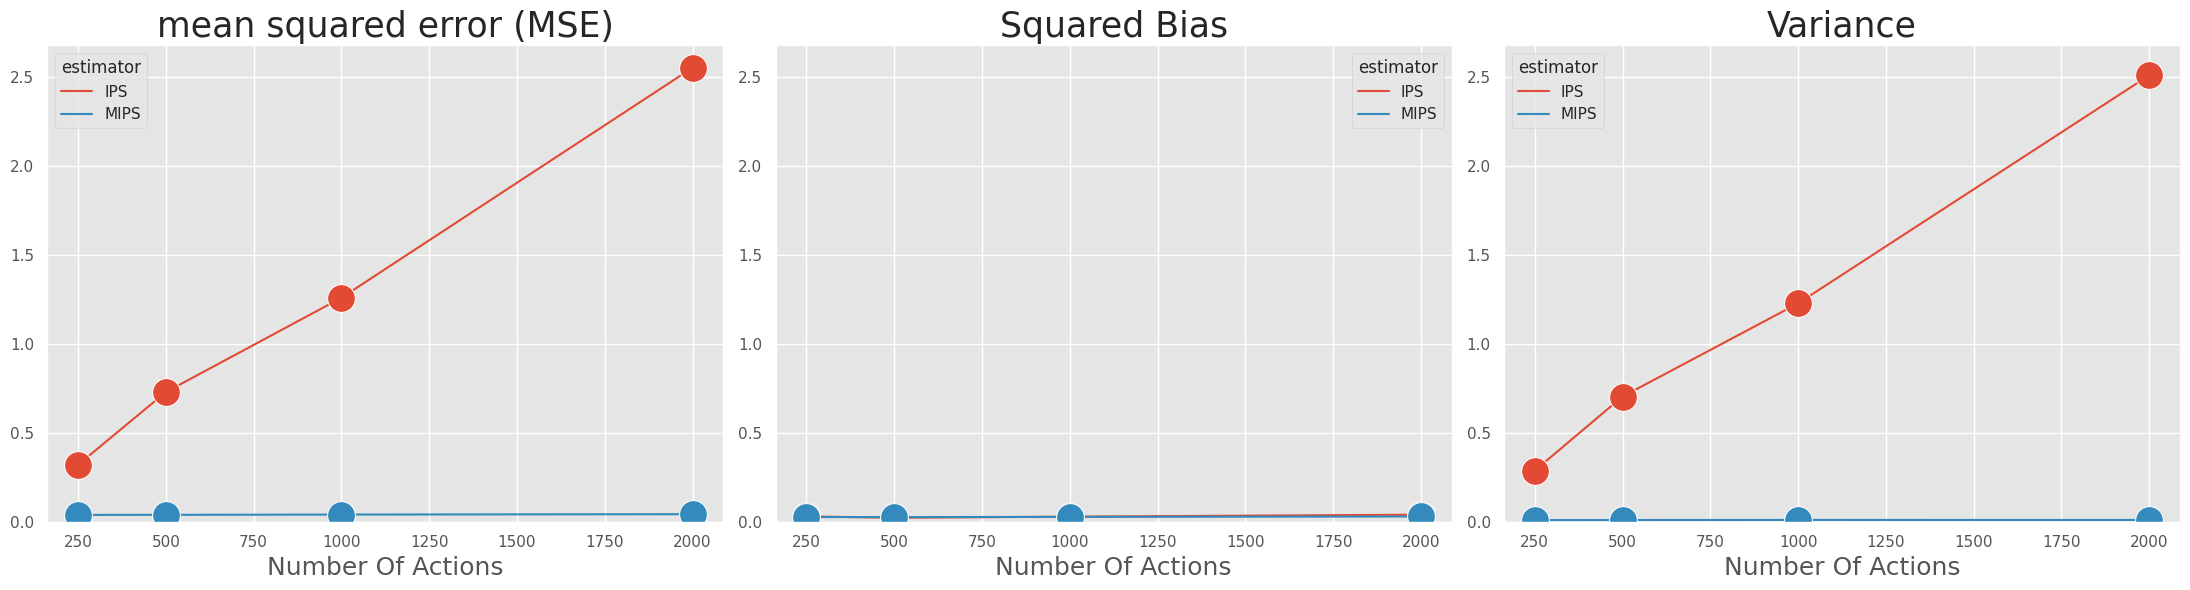

In [7]:
indicator = result_df["estimator"].isin(['IPS'])
visualize_mean_squared_error(result_df=result_df, xlabel="Number Of Actions")